# Video Description Generation and Query Retrieval

## Overview

This notebook demonstrates how to generate video descriptions using the [**Qwen 2.5 Vision-Language model**](https://github.com/QwenLM/Qwen2.5-VL) and store their embeddings in [**ChromaDB**](https://www.trychroma.com/) for efficient semantic search on **Intel® Core™ Ultra Processors**. The Qwen 2.5 Vision-Language model is loaded using the [**PyTorch XPU backend**](https://docs.pytorch.org/docs/stable/notes/get_start_xpu.html) to leverage Intel hardware acceleration.\
For each video, a description is generated and stored as an embedding in ChromaDB. When a user submits a query, cosine similarity search is performed in ChromaDB to retrieve the most relevant video description. The matching video is then displayed inline.\
This sample uses the videos from the [**stepfun-ai/Step-Video-T2V-Eval**](https://huggingface.co/datasets/stepfun-ai/Step-Video-T2V-Eval) Hugging Face dataset. For more information on the dataset and citation requirements, please refer to the [**Step-Video-T2V Technical Report paper**](https://arxiv.org/abs/2502.10248).

## Workflow

- During the initial data load, videos from the [*Step-Video-T2V-Eval*](https://huggingface.co/datasets/stepfun-ai/Step-Video-T2V-Eval) Hugging Face dataset is fed into the [*Qwen 2.5 Vision-Language model*](https://github.com/QwenLM/Qwen2.5-VL).
- Here, the [*Qwen2.5-VL-3B-Instruct*](https://huggingface.co/Qwen/Qwen2.5-VL-3B-Instruct) model variant is used to process these videos and generate descriptions. The Qwen 2.5 Vision-Language model is loaded using the [*PyTorch XPU backend*](https://docs.pytorch.org/docs/stable/notes/get_start_xpu.html) to leverage Intel hardware acceleration.
- Next, the generated video descriptions are converted into embeddings using [*Sentence Transformers*](https://sbert.net/), with the [*all-MiniLM-L6-v2 model*](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2).
- These embeddings, along with the descriptions and video metadata, are stored in a persistent local [*ChromaDB*](https://www.trychroma.com/) collection. This is a one-time operation; since ChromaDB is local and persistent, it does not need to be repeated unless new videos are added.
- When a user submits a query, the text is similarly encoded into an embedding, which is then used to perform a semantic search (via cosine similarity) over the ChromaDB collection.
- The final result will be the most relevant video description and its associated video file name, and the video is displayed directly in the notebook.

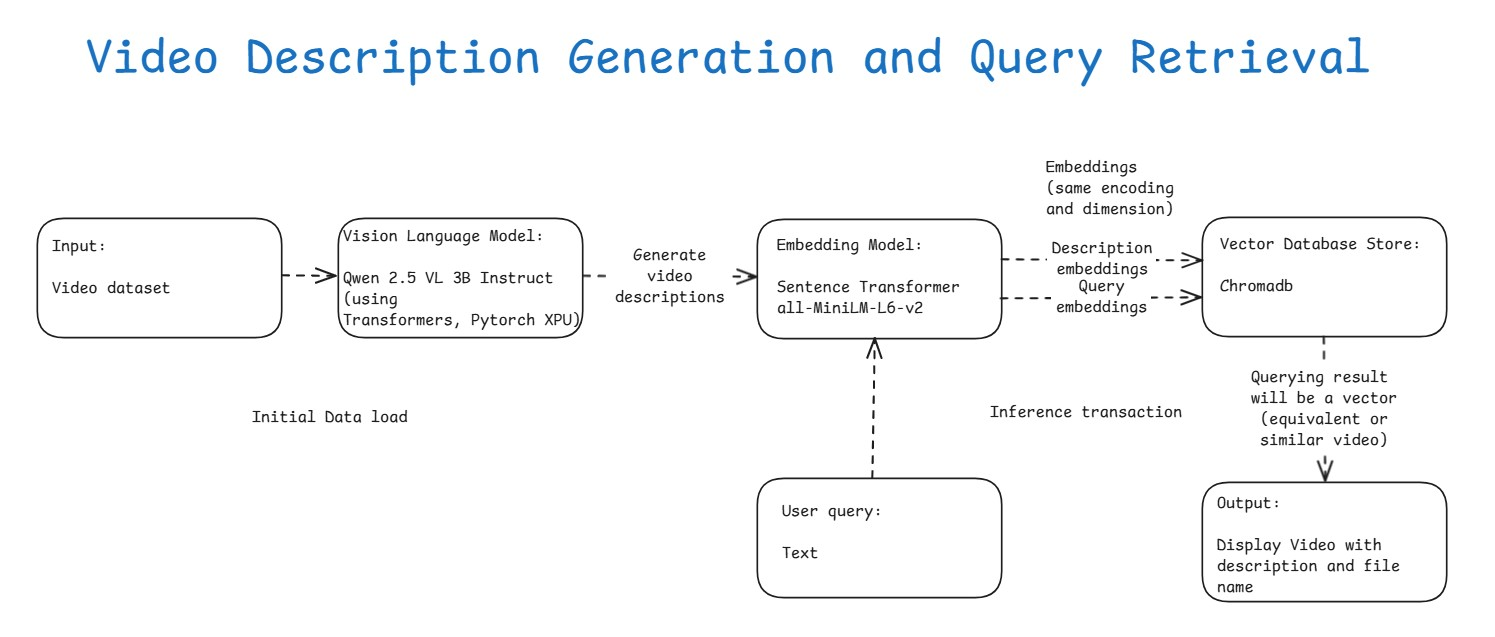

## Import necessary packages
Import all the necessary packages and libraries

In [1]:
import os
import torch
import random
import shutil
import zipfile
import logging
import chromadb
import warnings
from tqdm import tqdm
from IPython.display import Video, display
from huggingface_hub import notebook_login
from qwen_vl_utils import process_vision_info
from sentence_transformers import SentenceTransformer
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor

logging.basicConfig(level=logging.INFO)
warnings.filterwarnings("ignore")

## Login to Huggingface to download the models

- Log in to [Huggingface](https://huggingface.co/) using your credentials.
- You’ll need a [User Access Token](https://huggingface.co/docs/hub/security-tokens), which you can generate from your [Settings page](https://huggingface.co/settings/tokens). This token is used to authenticate your identity with the Hugging Face Hub.
- Once you've generated the token, copy it and keep it secure. Then, run the cell below and paste your access token when prompted.

In [2]:
notebook_login()

## Get video file paths
Select the number of videos to process and return the selected video file paths.

In [3]:
def get_video_paths():
    """
    Select the number of videos to process and return the selected video file paths.

    Returns:
        list: Selected list of video files paths.

    Raises:
        Exception: Raises an exception if there is any error during selecting the video paths.
    """
    try:
        dataset_folder = "Step-Video-T2V-Eval"
        max_videos_to_select = 128
        video_extensions = ['.mp4', '.avi', '.mov', '.mkv', '.flv', '.wmv']
        video_files = []
        for root, dirs, files in os.walk(dataset_folder):
            video_files.extend([os.path.join(root, f) for f in files if any(f.lower().endswith(ext) for ext in video_extensions)])
        total_video_files = len(video_files)
        num_videos_to_select = min(total_video_files, max_videos_to_select)
        random.seed(42)
        selected_video_files = random.sample(video_files, num_videos_to_select)
        logging.info(f" Total number of video files found: {total_video_files}\n")
        logging.info(f" Selected {num_videos_to_select} video files:")
        for file in selected_video_files:
            logging.info(file)
        return selected_video_files
    except Exception as e:
        logging.exception(f" Error while extracting the video paths: {str(e)}")

In [4]:
selected_video_files = get_video_paths()

INFO:root: Total number of video files found: 128

INFO:root: Selected 128 video files:
INFO:root:Step-Video-T2V-Eval\00000028.mp4
INFO:root:Step-Video-T2V-Eval\00000003.mp4
INFO:root:Step-Video-T2V-Eval\00000094.mp4
INFO:root:Step-Video-T2V-Eval\00000035.mp4
INFO:root:Step-Video-T2V-Eval\00000031.mp4
INFO:root:Step-Video-T2V-Eval\00000127.mp4
INFO:root:Step-Video-T2V-Eval\00000017.mp4
INFO:root:Step-Video-T2V-Eval\00000125.mp4
INFO:root:Step-Video-T2V-Eval\00000013.mp4
INFO:root:Step-Video-T2V-Eval\00000086.mp4
INFO:root:Step-Video-T2V-Eval\00000120.mp4
INFO:root:Step-Video-T2V-Eval\00000114.mp4
INFO:root:Step-Video-T2V-Eval\00000069.mp4
INFO:root:Step-Video-T2V-Eval\00000011.mp4
INFO:root:Step-Video-T2V-Eval\00000075.mp4
INFO:root:Step-Video-T2V-Eval\00000054.mp4
INFO:root:Step-Video-T2V-Eval\00000004.mp4
INFO:root:Step-Video-T2V-Eval\00000126.mp4
INFO:root:Step-Video-T2V-Eval\00000116.mp4
INFO:root:Step-Video-T2V-Eval\00000027.mp4
INFO:root:Step-Video-T2V-Eval\00000029.mp4
INFO:root

## Initialize models
Initialize the Vision Language Model(Qwen2.5-VL-3B-Instruct) and Sentence Transformer model(all-MiniLM-L6-v2).

In [5]:
def initialize_models():
    """
    Initialize Vision Language and Sentence Transformer models.

    Returns:
        dict: Dictionary containg the initialized Vision Language and Sentence Transformer models.

    Raises:
        Exception: Raises an exception if the model loading fails.
    """
    try:
        model_id = "Qwen/Qwen2.5-VL-3B-Instruct"
        embedding_model_id = "all-MiniLM-L6-v2"
        try:
            vl_model = Qwen2_5_VLForConditionalGeneration.from_pretrained(pretrained_model_name_or_path=model_id,
                                                                          local_files_only=True,
                                                                          torch_dtype=torch.float16)
            processor = AutoProcessor.from_pretrained(pretrained_model_name_or_path=model_id,
                                                      local_files_only=True,
                                                      min_pixels=256*14*14,
                                                      max_pixels=768*28*28,
                                                      use_fast=True)
        except Exception as e:
            print(f"Model '{model_id}' is not available locally. Please download it first using the CLI command( refer README)")
            raise
        device = "xpu" if torch.xpu.is_available() else "cpu"
        vl_model = vl_model.to(device)
        vl_model.eval()
        vl_model = torch.compile(vl_model)
        logging.info(f" Loading Qwen Vision Language Model: {model_id}")
        logging.info(f" Loading Qwen Vision Language Model onto the Pytorch device: {device}")
        try:
            embedding_model = SentenceTransformer(embedding_model_id, 
                                                 local_files_only=True) 
        except Exception as e:
            print(f"Model '{embedding_model_id}' is not available locally. Please download it first using the CLI command( refer README)")
            raise
        return {
            "vl_model": vl_model,
            "processor": processor,
            "embedding_model": embedding_model
        }
    except Exception as e:
        logging.exception(f" Error while loading the models: {str(e)}")

In [6]:
models = initialize_models()
vl_model = models["vl_model"]
processor = models["processor"]
embedding_model = models["embedding_model"]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.
INFO:root: Loading Qwen Vision Language Model: Qwen/Qwen2.5-VL-3B-Instruct
INFO:root: Loading Qwen Vision Language Model onto the Pytorch device: xpu
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


## Get or create Chromadb collection
Connects to the persistent ChromaDB client if already created. If there is no collection available it is going to create a new persistant ChromaDB collection for storing the Video descriptions and filenames. Here we are using cosine similarity for space parameter which will define the distance function of embedding space.

In [7]:
def get_or_create_database():
    """
    Connects to or creates a persistant ChromaDB collection for storing the Video descriptions and filenames.

    Returns:
        collection: The ChromaDB collection object.
        existing_descriptions (dict): The dictionary contains video descriptions of the existing Chromadb database collection.

    Raises:
        Exception: Raises an exception if there is any error while checking an existing database.
    """
    try:
        client = chromadb.PersistentClient(path="./Video_descriptions_database")
        collection = client.get_or_create_collection(
            name="Video_descriptions", 
            configuration={
                "hnsw": {
                    "space": "cosine",
                },
            }
        )
        logging.info(" Checking existing descriptions in database..")
        all_items = collection.get(include=["metadatas", "documents"])
        existing_descriptions = {}
        for metadata, doc in zip(all_items['metadatas'], all_items['documents']):
            existing_descriptions[metadata['video_filename']] = doc
        logging.info(f" Found {len(existing_descriptions)} existing descriptions")
        return collection, existing_descriptions
    except Exception as e:
        existing_descriptions = {}
        logging.exception(" No existing descriptions found")
        logging.exception(f" Error while checking an existing database: {str(e)}")

In [8]:
collection, existing_descriptions = get_or_create_database()

INFO:chromadb.telemetry.product.posthog:Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
INFO:root: Checking existing descriptions in database..
INFO:root: Found 0 existing descriptions


## Generate and store video descriptions
Each file in the selected video files list will be checked to determine whether it has already generated video description and stored in the database. If the file is not present in the collection database, a description will be generated by the Qwen model and stored in the collection database.

In [11]:
def generate_and_store_video_descriptions(selected_video_files, collection, existing_descriptions, vl_model, processor, embedding_model):
    """
    Check and generate video description for each video file in the selected directory.
    Store the embeddings of generated video descriptions in the ChromaDB collection.
    
    Args:
        selected_video_files (list): List of selected video files.
        collection: The ChromaDB collection object.
        existing_descriptions (dict): The dictionary contains video descriptions of the existing Chromadb database collection.
        vl_model: Vision Language Model for generating video descriptions.
        processor: Vision Language Model processor for processing videos.
        embedding_model: Sentence Transformer Model for generating embeddings.

    Raises:
        Exception: Raises an exception if there is any error while generating video descriptions or storing the embeddings in the database.
    """
    try:
        video_descriptions = {}
        for i, video_file in enumerate(tqdm(selected_video_files)):
            video_filename = os.path.basename(video_file)
            if video_filename in existing_descriptions:
                logging.info(f" Skipping file {os.path.basename(video_file)} - video description already present in the database")
                video_descriptions[video_file] = existing_descriptions[video_filename]
                continue

            video_path = video_file
            torch.xpu.empty_cache()
            logging.info(f"\n Processing file {os.path.basename(video_file)} using Qwen 2.5 VL on Pytorch XPU..")
            messages = [
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "video",
                            "video": video_path,
                            "max_pixels": 320*240,
                            "fps": 0.5,
                        },
                        {
                            "type": "text",
                            "text": "Describe this sports video."
                        },
                    ],
                }
            ]
            text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
            image_inputs, video_inputs = process_vision_info(messages)
            inputs = processor(
                text=[text],
                images=image_inputs,
                videos=video_inputs,
                padding=True,
                return_tensors="pt",
            )
            inputs = inputs.to("xpu")
            with torch.no_grad():
                generated_ids = vl_model.generate(**inputs, max_new_tokens=128)
                generated_ids_trimmed = [
                    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
                ]
                output_text = processor.batch_decode(
                    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
                )
            description_text = output_text[0] if isinstance(output_text, list) else str(output_text)
            video_descriptions[video_file] = description_text
            logging.info(f" Generated description: {description_text}.\n")
            torch.xpu.synchronize()
            embedding = embedding_model.encode(sentences=description_text).tolist()
            collection.add(
                embeddings=[embedding],
                documents=[description_text],
                metadatas=[{"video_filename": os.path.basename(video_file)}],
                ids=[video_file]
            )
            logging.info(f" Added {os.path.basename(video_file)} video file description to database\n\n")
        logging.info(f" Processed {len(video_descriptions)} videos")
        logging.info(f" Database now has {collection.count()} total descriptions")
    except Exception as e:
        logging.exception(f" Error while generating and storing video descriptions: {str(e)}")

<div class="alert alert-warning" role="alert">
  Generating video descriptions and updating the database. This may take some time.
</div>

In [12]:
generate_and_store_video_descriptions(selected_video_files, collection, existing_descriptions, vl_model, processor, embedding_model)    

  0%|                                                                                                                                                                                     | 0/128 [00:00<?, ?it/s]INFO:root:
 Processing file 00000028.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000028.mp4', total_frames=204, video_fps=25.0, time=0.117s
INFO:root: Generated description: The image depicts a wide, open square with a prominent red brick wall on the right side. In the background, there is a large, historic building with multiple towers and spires, which appears to be a significant architectural structure, possibly a palace or a cathedral. The sky is clear and blue, suggesting it might be early morning or late afternoon.

The square is paved with cobblestones and is relatively empty, with only a few people visible in the distance. The overall atmosphere of the image is serene and majestic, highlighting the g

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000028.mp4 video file description to database


  1%|█▎                                                                                                                                                                         | 1/128 [00:47<1:39:50, 47.17s/it]INFO:root:
 Processing file 00000003.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000003.mp4', total_frames=204, video_fps=25.0, time=0.213s
INFO:root: Generated description: The video shows an athlete running on a track. The runner is wearing a blue shirt, black shorts, and running shoes. The track is outdoors, with green grass and trees visible in the background. The runner appears to be in motion, with their legs and feet clearly visible as they run. The video captures the athlete's movement and the surrounding environment..



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000003.mp4 video file description to database


  2%|██▋                                                                                                                                                                        | 2/128 [01:13<1:13:26, 34.97s/it]INFO:root:
 Processing file 00000094.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000094.mp4', total_frames=204, video_fps=25.0, time=0.139s
INFO:root: Generated description: The image depicts a scene from the movie "Transformers: Revenge of the Fallen." The central figure is Optimus Prime, a red and silver robot with a large, muscular build. He stands in an open, outdoor setting with a clear blue sky and some rocky formations in the background. The environment appears to be a battlefield or a training ground, with structures that resemble ancient ruins or fortifications. The overall atmosphere suggests a moment of confrontation or preparation

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000094.mp4 video file description to database


  2%|████                                                                                                                                                                       | 3/128 [01:47<1:12:13, 34.67s/it]INFO:root:
 Processing file 00000035.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000035.mp4', total_frames=204, video_fps=25.0, time=0.149s
INFO:root: Generated description: The video depicts a majestic lion walking through a grassy savannah landscape. The lion's mane is prominently displayed, and the golden hues of the setting sun cast a warm glow over the scene. The lion appears to be moving with purpose, likely on the hunt or exploring its territory. The vast expanse of the savannah, with scattered trees and bushes in the distance, provides a serene and natural backdrop for this powerful and graceful creature..



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000035.mp4 video file description to database


  3%|█████▎                                                                                                                                                                     | 4/128 [02:21<1:10:53, 34.30s/it]INFO:root:
 Processing file 00000031.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000031.mp4', total_frames=204, video_fps=25.0, time=0.276s
INFO:root: Generated description: The image depicts a modern cityscape with numerous high-rise buildings, including skyscrapers and office towers. The architecture features glass facades and sleek designs, typical of contemporary urban environments. The sky is clear and blue, suggesting a sunny day. The overall scene conveys a sense of modernity, efficiency, and possibly economic prosperity..



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000031.mp4 video file description to database


  4%|██████▋                                                                                                                                                                    | 5/128 [02:47<1:03:44, 31.09s/it]INFO:root:
 Processing file 00000127.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000127.mp4', total_frames=204, video_fps=25.0, time=0.204s
INFO:root: Generated description: The image shows a person eating instant noodles from a red and white cup. The setting appears to be a cozy, rustic kitchen or dining area with various items on the shelves and countertops in the background. The person is wearing a green shirt and seems to be enjoying their meal. The overall atmosphere suggests a casual, homey environment..



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000127.mp4 video file description to database


  5%|████████                                                                                                                                                                     | 6/128 [03:11<58:50, 28.94s/it]INFO:root:
 Processing file 00000017.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000017.mp4', total_frames=204, video_fps=25.0, time=0.134s
INFO:root: Generated description: The video shows a close-up of three tacos on a wooden cutting board. The tacos are filled with ground meat, diced tomatoes, onions, and cilantro. There is also a lime wedge and a small bowl of guacamole in the background. The video appears to be a food-related video, possibly showcasing a recipe or a dish..



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000017.mp4 video file description to database


  5%|█████████▍                                                                                                                                                                   | 7/128 [03:37<56:19, 27.93s/it]INFO:root:
 Processing file 00000125.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000125.mp4', total_frames=204, video_fps=25.0, time=0.100s
INFO:root: Generated description: The video depicts a minimalist, futuristic environment with a stark white color scheme. The setting is an expansive, empty room with smooth, reflective surfaces and high ceilings. The lighting is bright and even, casting soft shadows that create a sense of depth and dimensionality. There are several doors and panels along the walls, suggesting a functional or industrial design. A lone figure stands in the center of the room, facing away from the camera, adding a sense of 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000125.mp4 video file description to database


  6%|██████████▋                                                                                                                                                                | 8/128 [04:21<1:06:11, 33.09s/it]INFO:root:
 Processing file 00000013.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000013.mp4', total_frames=204, video_fps=25.0, time=0.140s
INFO:root: Generated description: The video shows a close-up of a plate of food, specifically a piece of meat that appears to be cooked and glazed with a dark sauce. The meat is sliced and arranged on the plate, with a fork piercing one of the slices. The background is blurred, but it seems to be a dimly lit setting, possibly a restaurant or a dining area. The focus is on the presentation and the texture of the meat, highlighting its juicy and well-cooked appearance..



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000013.mp4 video file description to database


  7%|████████████                                                                                                                                                               | 9/128 [04:56<1:06:48, 33.69s/it]INFO:root:
 Processing file 00000086.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000086.mp4', total_frames=204, video_fps=25.0, time=0.160s
INFO:root: Generated description: The video depicts two individuals in white lab coats working at a desk in what appears to be a laboratory or control room setting. They are focused on multiple computer monitors displaying various data and graphs, suggesting they are monitoring or analyzing some form of scientific or technical information.

The environment is clean and well-lit, with a modern and professional atmosphere. The individuals seem to be engaged in their work, possibly conducting experiments or 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000086.mp4 video file description to database


  8%|█████████████▎                                                                                                                                                            | 10/128 [05:42<1:13:34, 37.41s/it]INFO:root:
 Processing file 00000120.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000120.mp4', total_frames=204, video_fps=25.0, time=0.164s
INFO:root: Generated description: The image depicts a vibrant and dramatic scene of a city street during sunset or sunrise, with the sky painted in deep shades of red and orange. The buildings lining the street are silhouetted against the bright sky, creating a striking contrast. People are walking along the sidewalk, adding a sense of movement and life to the scene. The overall atmosphere is one of warmth and energy, with the warm colors of the sky and the people's silhouettes creating a visually captiva

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000120.mp4 video file description to database


  9%|██████████████▌                                                                                                                                                           | 11/128 [06:17<1:11:37, 36.73s/it]INFO:root:
 Processing file 00000114.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000114.mp4', total_frames=204, video_fps=25.0, time=0.222s
INFO:root: Generated description: The video shows a man sitting at a table in what appears to be a restaurant or café. He is wearing a blue button-up shirt and has short dark hair. The setting includes other people seated at tables, and there are large windows that let in natural light, suggesting it might be daytime. The background shows some outdoor elements, possibly trees and buildings, indicating the location could be near a park or urban area. The overall atmosphere seems casual and relaxed..



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000114.mp4 video file description to database


  9%|███████████████▉                                                                                                                                                          | 12/128 [06:51<1:09:00, 35.70s/it]INFO:root:
 Processing file 00000069.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000069.mp4', total_frames=204, video_fps=25.0, time=0.221s
INFO:root: Generated description: The video depicts an aerial view of a large agricultural field where a red tractor is harvesting crops. The tractor is equipped with a large, flat attachment that appears to be a combine harvester, designed for cutting and collecting crops like corn or soybeans. The field is divided into rows of crops, with the tractor moving along the rows, efficiently harvesting the plants.

The surrounding area outside the field is also visible, showing more rows of crops extending int

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000069.mp4 video file description to database


 10%|█████████████████▎                                                                                                                                                        | 13/128 [07:36<1:14:03, 38.64s/it]INFO:root:
 Processing file 00000011.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000011.mp4', total_frames=204, video_fps=25.0, time=0.217s
INFO:root: Generated description: The video captures an athletic event, likely a track and field competition, specifically focusing on a long jump. The scene is set in an indoor stadium filled with spectators. The athlete, dressed in a red and white uniform, is seen approaching the takeoff board. The athlete's form is athletic and focused as they prepare to launch themselves into the air.

As the athlete leaps, their body extends forward, showcasing the power and technique required for a successful long j

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000011.mp4 video file description to database


 11%|██████████████████▌                                                                                                                                                       | 14/128 [08:22<1:17:25, 40.75s/it]INFO:root:
 Processing file 00000075.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000075.mp4', total_frames=204, video_fps=25.0, time=0.174s
INFO:root: Generated description: The video depicts a dynamic scene of Spider-Man swinging through a bustling cityscape. The iconic superhero is seen leaping from one skyscraper to another, using his web-slinging abilities to navigate the urban environment. The city is filled with tall buildings, and the sky is clear, suggesting it's a sunny day. The action is fast-paced, capturing the agility and acrobatic prowess of Spider-Man as he swings between structures..



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000075.mp4 video file description to database


 12%|███████████████████▉                                                                                                                                                      | 15/128 [08:53<1:11:38, 38.04s/it]INFO:root:
 Processing file 00000054.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000054.mp4', total_frames=204, video_fps=25.0, time=0.126s
INFO:root: Generated description: The video shows a group of children dressed in blue uniforms with red scarves, standing in a line on a street. They appear to be participating in an event or activity, as some of them are holding red flags and others are waving. The children seem to be smiling and enjoying themselves. The background shows a cityscape with buildings and trees, indicating that the event is taking place outdoors in an urban area. The overall atmosphere appears to be lively and cheerful..



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000054.mp4 video file description to database


 12%|█████████████████████▎                                                                                                                                                    | 16/128 [09:27<1:08:27, 36.67s/it]INFO:root:
 Processing file 00000004.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000004.mp4', total_frames=204, video_fps=25.0, time=0.216s
INFO:root: Generated description: The video captures an intense moment from a badminton match. Two players, both dressed in pink and white uniforms, are engaged in a rally on the court. The player on the left is in the process of hitting the shuttlecock with his racket, while the player on the right is preparing to return the shot. The background shows a well-lit indoor stadium with spectators seated in the stands, and various banners and advertisements are visible around the court. The atmosphere is ener

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000004.mp4 video file description to database


 13%|██████████████████████▌                                                                                                                                                   | 17/128 [10:06<1:09:08, 37.38s/it]INFO:root:
 Processing file 00000126.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000126.mp4', total_frames=204, video_fps=25.0, time=0.189s
INFO:root: Generated description: The video depicts a vibrant and colorful autumn forest scene. The trees are adorned with a variety of fall foliage, including shades of red, orange, yellow, and green, creating a stunning and picturesque landscape. The sky is clear with a soft gradient of blue and pink hues, suggesting either sunrise or sunset. Birds are seen flying in the sky, adding life and movement to the tranquil setting. The overall atmosphere is serene and beautiful, capturing the essence of a peac

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000126.mp4 video file description to database


 14%|███████████████████████▉                                                                                                                                                  | 18/128 [10:41<1:07:20, 36.73s/it]INFO:root:
 Processing file 00000116.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000116.mp4', total_frames=204, video_fps=25.0, time=0.190s
INFO:root: Generated description: The video depicts a vibrant and nostalgic scene of a classic American city street during sunset. The setting is reminiscent of the 1950s, with vintage cars driving down the street, adding to the retro atmosphere. The buildings have neon signs, including one that reads "Coca-Cola," which is illuminated in red. The street is lined with various shops and businesses, some of which have striped awnings. The sky is painted with hues of orange and pink as the sun sets, casting a

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000116.mp4 video file description to database


 15%|█████████████████████████▏                                                                                                                                                | 19/128 [11:27<1:11:31, 39.38s/it]INFO:root:
 Processing file 00000027.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000027.mp4', total_frames=204, video_fps=25.0, time=0.157s
INFO:root: Generated description: The video showcases a serene and picturesque view of the Shanghai skyline, captured from across the Huangpu River. The scene is bathed in the soft, warm light of either early morning or late afternoon, creating a tranquil atmosphere. The iconic Oriental Pearl Tower stands prominently on the left side of the frame, its distinctive shape and height making it a recognizable landmark. To the right, the Shanghai Tower rises, adding to the city's modern architectural marvels.



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000027.mp4 video file description to database


 16%|██████████████████████████▌                                                                                                                                               | 20/128 [12:12<1:14:11, 41.21s/it]INFO:root:
 Processing file 00000029.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000029.mp4', total_frames=204, video_fps=25.0, time=0.190s
INFO:root: Generated description: The video showcases the iconic Golden Gate Bridge in San Francisco, California. The bridge is prominently featured, with its distinctive red-orange color and suspension towers spanning across the San Francisco Bay. The sky is clear, suggesting it might be early morning or late afternoon, as the lighting is soft and warm. The water below is calm, with a few boats visible in the distance, adding to the serene atmosphere. The overall scene captures the beauty and grandeur of

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000029.mp4 video file description to database


 16%|███████████████████████████▉                                                                                                                                              | 21/128 [12:48<1:10:45, 39.67s/it]INFO:root:
 Processing file 00000064.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000064.mp4', total_frames=204, video_fps=25.0, time=0.110s
INFO:root: Generated description: The video depicts a person sitting at a table in a café with large windows, looking out at a scenic view of a cityscape. The person is working on a laptop, and there are other tables and chairs visible in the background. The café has a cozy atmosphere with red chairs and a view of buildings and a river or canal outside. The lighting suggests it might be daytime..



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000064.mp4 video file description to database


 17%|█████████████████████████████▏                                                                                                                                            | 22/128 [13:16<1:03:51, 36.14s/it]INFO:root:
 Processing file 00000077.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000077.mp4', total_frames=204, video_fps=25.0, time=0.218s
INFO:root: Generated description: The video depicts a character in a red and black superhero costume running down a city street. The character is wearing a suit with a cape and has a glowing effect around their body, suggesting they might be a superhero or a character with special powers. The background shows tall buildings and parked cars, indicating an urban setting. The scene is dynamic, with the character moving quickly and confidently through the cityscape..



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000077.mp4 video file description to database


 18%|██████████████████████████████▉                                                                                                                                             | 23/128 [13:46<59:42, 34.11s/it]INFO:root:
 Processing file 00000110.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000110.mp4', total_frames=204, video_fps=25.0, time=0.139s
INFO:root: Generated description: The video depicts a serene and expansive landscape featuring a vast, golden-yellow grassy field stretching towards the horizon. In the distance, majestic mountains rise against a clear blue sky, their peaks shrouded in a light mist or haze. The scene is tranquil, with no visible human activity or wildlife, emphasizing the natural beauty and tranquility of the environment. The overall atmosphere is peaceful and picturesque, capturing the essence of a rural, open countrysid

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000110.mp4 video file description to database


 19%|████████████████████████████████▎                                                                                                                                           | 24/128 [14:18<58:12, 33.59s/it]INFO:root:
 Processing file 00000071.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000071.mp4', total_frames=204, video_fps=25.0, time=0.162s
INFO:root: Generated description: The image depicts a stunning desert landscape under a starry night sky. The scene features vast, undulating sand dunes that stretch across the horizon, their golden hues contrasting with the deep blue of the night sky. Above, the Milky Way galaxy is prominently visible, its swirling arms and countless stars creating a breathtaking backdrop. A small body of water, possibly a lake or pond, reflects the vibrant colors of the sky, adding a serene element to the otherwise rugg

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000071.mp4 video file description to database


 20%|█████████████████████████████████▏                                                                                                                                        | 25/128 [15:01<1:02:35, 36.46s/it]INFO:root:
 Processing file 00000025.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000025.mp4', total_frames=204, video_fps=25.0, time=0.212s
INFO:root: Generated description: The image depicts a serene forest scene with lush greenery and tall trees. The sunlight filters through the dense canopy, casting dappled light on the forest floor covered with moss, fallen leaves, and small plants. The overall atmosphere is peaceful and natural, capturing the beauty of a thriving woodland environment..



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000025.mp4 video file description to database


 20%|██████████████████████████████████▉                                                                                                                                         | 26/128 [15:24<54:57, 32.32s/it]INFO:root:
 Processing file 00000091.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000091.mp4', total_frames=204, video_fps=25.0, time=0.141s
INFO:root: Generated description: The video depicts a scene in a gym where two men are engaged in a conversation while one of them is demonstrating a workout routine. The man being demonstrated on is shirtless, showcasing his muscular physique, and appears to be performing a squat exercise. He is wearing black shorts and has a tattoo on his left arm. The other man, who is standing behind him, is dressed in a black t-shirt and dark pants. He is gesturing with his hands as he speaks, possibly providing inst

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000091.mp4 video file description to database


 21%|███████████████████████████████████▊                                                                                                                                      | 27/128 [16:09<1:01:06, 36.31s/it]INFO:root:
 Processing file 00000083.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000083.mp4', total_frames=204, video_fps=25.0, time=0.131s
INFO:root: Generated description: The video depicts an individual engaged in the act of painting on a canvas. The person is standing in front of an easel, holding a paintbrush and applying strokes to the canvas. The canvas features abstract shapes and colors, primarily in shades of blue, red, and green. The setting appears to be a well-lit studio or art room, with other artworks visible in the background. The overall atmosphere suggests a creative and focused environment dedicated to artistic expression..

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000083.mp4 video file description to database


 22%|█████████████████████████████████████▋                                                                                                                                      | 28/128 [16:43<59:02, 35.42s/it]INFO:root:
 Processing file 00000089.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000089.mp4', total_frames=204, video_fps=25.0, time=0.190s
INFO:root: Generated description: The video shows a group of individuals in military-style uniforms standing in formation. The uniforms appear to be camouflage-patterned, and the individuals have short haircuts. The setting seems to be an outdoor area, possibly a training ground or a military base. The individuals are facing forward, suggesting they are either preparing for or participating in a formal event or ceremony. The overall atmosphere is disciplined and organized..



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000089.mp4 video file description to database


 23%|██████████████████████████████████████▉                                                                                                                                     | 29/128 [17:12<55:19, 33.53s/it]INFO:root:
 Processing file 00000115.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000115.mp4', total_frames=204, video_fps=25.0, time=0.145s
INFO:root: Generated description: The video depicts a serene and picturesque garden scene. A person dressed in traditional attire, possibly a hanfu, is walking through the garden. The garden is lush with vibrant greenery and colorful flowers, including pink and purple blooms. The person appears to be enjoying the peaceful environment, surrounded by nature's beauty. The overall atmosphere of the video is tranquil and aesthetically pleasing, capturing the essence of a harmonious and idyllic setting..



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000115.mp4 video file description to database


 23%|████████████████████████████████████████▎                                                                                                                                   | 30/128 [17:44<54:13, 33.20s/it]INFO:root:
 Processing file 00000053.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000053.mp4', total_frames=204, video_fps=25.0, time=0.220s
INFO:root: Generated description: The video depicts a group of young boys engaged in a playful water fight outdoors on a sunny day. They are standing in a line, facing each other, and holding blue buckets filled with water. The boys are dressed in casual summer clothing, including shorts and tank tops. Some of them are shirtless, while others have their shirts tied around their waists. The background shows a grassy area with trees and a clear blue sky, indicating that it is likely summer or spring. The bo

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000053.mp4 video file description to database


 24%|█████████████████████████████████████████▋                                                                                                                                  | 31/128 [18:30<59:45, 36.97s/it]INFO:root:
 Processing file 00000122.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000122.mp4', total_frames=204, video_fps=25.0, time=0.269s
INFO:root: Generated description: The video showcases an ornately decorated hallway, likely within a grand building such as a palace or a museum. The walls and ceiling are adorned with intricate paintings and sculptures, featuring various floral and mythological motifs. The lighting is soft and warm, enhancing the opulent atmosphere. People can be seen walking along the corridor, adding a sense of scale to the scene. The overall ambiance is one of elegance and historical significance..



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000122.mp4 video file description to database


 25%|███████████████████████████████████████████                                                                                                                                 | 32/128 [19:01<56:13, 35.14s/it]INFO:root:
 Processing file 00000057.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000057.mp4', total_frames=204, video_fps=25.0, time=0.232s
INFO:root: Generated description: The video showcases a dragon boat race, a traditional and competitive event in many Asian cultures, particularly China. The scene is set on a calm body of water, likely a lake or river, with several long, narrow boats known as dragon boats. Each boat is manned by a team of rowers who are dressed in matching uniforms, which in this case are red shirts and black pants.

The dragon boats are adorned with intricate designs, including the head of a dragon at the front and vari

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000057.mp4 video file description to database


 26%|███████████████████████████████████████████▊                                                                                                                              | 33/128 [19:46<1:00:36, 38.28s/it]INFO:root:
 Processing file 00000113.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000113.mp4', total_frames=204, video_fps=25.0, time=0.253s
INFO:root: Generated description: The video depicts a serene and lush forest scene. The camera is positioned at the ground level, providing a first-person perspective as it moves forward along a dirt path that winds through the dense greenery. The path is lined with tall trees whose trunks stretch upwards, creating a canopy of leaves overhead. The ground is covered with fallen leaves and twigs, adding to the natural and untouched feel of the environment. The vibrant green foliage on both sides of the path

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000113.mp4 video file description to database


 27%|█████████████████████████████████████████████▏                                                                                                                            | 34/128 [20:30<1:02:18, 39.78s/it]INFO:root:
 Processing file 00000124.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000124.mp4', total_frames=204, video_fps=25.0, time=0.188s
INFO:root: Generated description: The video depicts a vibrant urban scene featuring a narrow alleyway lined with colorful graffiti-covered walls. The alley is bustling with activity, as several people are walking along the street, some of whom appear to be tourists or visitors. The graffiti on the walls is diverse and includes various styles and designs, contributing to the lively and artistic atmosphere of the area. The buildings flanking the alley are painted in bright colors, adding to the overall aest

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000124.mp4 video file description to database


 27%|██████████████████████████████████████████████▍                                                                                                                           | 35/128 [21:12<1:03:02, 40.67s/it]INFO:root:
 Processing file 00000000.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000000.mp4', total_frames=204, video_fps=25.0, time=0.189s
INFO:root: Generated description: The video depicts a soccer match in progress on a green field. A player in a blue and red striped jersey is dribbling the ball towards the goal. The goalkeeper, dressed in white, is positioned near the goalpost, ready to defend. The scene captures the intensity of the game as the player attempts to score, with the goalkeeper attempting to block the shot. The focus is on the action around the goal area, highlighting the skill and determination of both players involved..



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000000.mp4 video file description to database


 28%|████████████████████████████████████████████████▍                                                                                                                           | 36/128 [21:47<59:23, 38.73s/it]INFO:root:
 Processing file 00000020.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000020.mp4', total_frames=204, video_fps=25.0, time=0.242s
INFO:root: Generated description: The video showcases a variety of grilled dishes, likely from a barbecue or grilling event. The focus is on the preparation and presentation of different types of food. Here's a detailed description:

1. **Grilled Pizza**: A pizza is being placed on a grill, with toppings visible. The pizza appears to be topped with cheese, possibly some vegetables like bell peppers and onions, and a sauce that could be tomato-based.

2. **Grilled Skewers**: Several skewers are being cooke

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000020.mp4 video file description to database


 29%|█████████████████████████████████████████████████▏                                                                                                                        | 37/128 [22:32<1:01:50, 40.78s/it]INFO:root:
 Processing file 00000099.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000099.mp4', total_frames=204, video_fps=25.0, time=0.156s
INFO:root: Generated description: The video depicts an animated character, likely a panda, performing martial arts in a traditional Asian setting. The panda is dressed in black and white attire, with a black headband featuring a white symbol. It is executing a series of dynamic martial arts moves, including a spinning kick and a high jump kick. The background shows a thatched-roof building, possibly a temple or a traditional house, surrounded by lush greenery and trees. The scene is vibrant and energetic,

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000099.mp4 video file description to database


 30%|██████████████████████████████████████████████████▍                                                                                                                       | 38/128 [23:11<1:00:21, 40.24s/it]INFO:root:
 Processing file 00000112.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000112.mp4', total_frames=204, video_fps=25.0, time=0.364s
INFO:root: Generated description: The image depicts a vibrant cityscape at dusk or early evening, with the sky transitioning from deep blue to hues of pink and purple. The scene is illuminated by streetlights and the glow of buildings, creating a warm and inviting atmosphere. 

In the foreground, there is a large, circular structure that appears to be a festive display or a landmark, possibly a Christmas tree or a similar decorative element. This structure is adorned with lights and decorations, adding to

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000112.mp4 video file description to database


 30%|███████████████████████████████████████████████████▊                                                                                                                      | 39/128 [23:57<1:02:08, 41.89s/it]INFO:root:
 Processing file 00000043.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000043.mp4', total_frames=204, video_fps=25.0, time=0.236s
INFO:root: Generated description: The video depicts two kangaroos in a natural, arid environment, likely a savanna or desert landscape. The kangaroos are captured mid-jump, with their powerful hind legs extended forward and their front legs bent at the elbow. The kangaroo on the left is slightly ahead of the one on the right, creating a dynamic sense of movement and speed. The background features sparse vegetation and a clear sky, suggesting it might be either early morning or late afternoon due to the wa

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000043.mp4 video file description to database


 31%|█████████████████████████████████████████████████████▏                                                                                                                    | 40/128 [24:41<1:02:28, 42.59s/it]INFO:root:
 Processing file 00000093.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000093.mp4', total_frames=204, video_fps=25.0, time=0.142s
INFO:root: Generated description: The image depicts an animated character from the "Toy Story" franchise, specifically Buzz Lightyear. He is standing in what appears to be a colorful, playful environment, likely a playroom or a similar setting. Buzz Lightyear is wearing his iconic green and purple space ranger suit with a white shirt underneath. His chest has a large, rectangular panel with various buttons and labels, including one that reads "BEEP BOOP." The background features bright colors and playful 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000093.mp4 video file description to database


 32%|███████████████████████████████████████████████████████                                                                                                                     | 41/128 [25:19<59:51, 41.28s/it]INFO:root:
 Processing file 00000019.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000019.mp4', total_frames=204, video_fps=25.0, time=0.252s
INFO:root: Generated description: The image depicts a beautifully presented dish of grilled fish. The fish appears to be a type of salmon or trout, characterized by its golden-brown, slightly charred skin and visible grill marks. It is garnished with fresh rosemary sprigs and slices of lemon, adding a touch of green and bright yellow color contrast. The fish is placed on a dark plate, which helps to highlight the vibrant colors of the food. Surrounding the fish are slices of cherry tomatoes and possibly s

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000019.mp4 video file description to database


 33%|███████████████████████████████████████████████████████▊                                                                                                                  | 42/128 [26:05<1:01:05, 42.62s/it]INFO:root:
 Processing file 00000108.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000108.mp4', total_frames=204, video_fps=25.0, time=0.347s
INFO:root: Generated description: The video showcases a breathtaking aerial view of a mountainous landscape, featuring a serene lake nestled among towering cliffs and dense forests. The camera pans across the scene, capturing the vast expanse of the lake, its crystal-clear waters reflecting the surrounding greenery and rugged terrain. The mountains rise majestically in the background, their peaks dusted with snow, creating a stunning contrast against the clear blue sky. The overall atmosphere is tranquil 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000108.mp4 video file description to database


 34%|█████████████████████████████████████████████████████████▊                                                                                                                  | 43/128 [26:42<57:43, 40.75s/it]INFO:root:
 Processing file 00000088.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000088.mp4', total_frames=204, video_fps=25.0, time=0.173s
INFO:root: Generated description: The video shows a person working in a field, likely tending to crops or plants. The individual is bending over and appears to be engaged in some form of agricultural activity. The setting is an open field with rows of green plants, suggesting it might be a vegetable or crop farm. The sky is clear, indicating it could be a sunny day. The overall atmosphere conveys a sense of rural life and the work involved in farming..



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000088.mp4 video file description to database


 34%|███████████████████████████████████████████████████████████▏                                                                                                                | 44/128 [27:13<53:16, 38.06s/it]INFO:root:
 Processing file 00000119.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000119.mp4', total_frames=204, video_fps=25.0, time=0.147s
INFO:root: Generated description: The image depicts a surreal and futuristic scene set in a desert landscape. The central focus is a large, eye-like structure with multiple eyes and a mouth, which appears to be a giant, floating pyramid or tower. The structure has a metallic, reflective surface and is adorned with various mechanical and technological elements.

In the foreground, there are several people standing on a sandy platform, observing the towering structure. The sky above is filled with floating 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000119.mp4 video file description to database


 35%|████████████████████████████████████████████████████████████▍                                                                                                               | 45/128 [27:59<55:43, 40.28s/it]INFO:root:
 Processing file 00000109.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000109.mp4', total_frames=204, video_fps=25.0, time=0.111s
INFO:root: Generated description: The video showcases a painting displayed in an art gallery. The painting depicts a lively scene of people gathered in what appears to be a public square or market area. The setting is vibrant, with colorful clothing and detailed architectural elements. The figures are engaged in various activities, suggesting a bustling, social environment. The artwork is framed and hung on a wall, with descriptive text below it, likely providing information about the painting's title, ar

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000109.mp4 video file description to database


 36%|█████████████████████████████████████████████████████████████▊                                                                                                              | 46/128 [28:41<55:51, 40.88s/it]INFO:root:
 Processing file 00000048.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000048.mp4', total_frames=204, video_fps=25.0, time=0.127s
INFO:root: Generated description: The video depicts a young child dressed in traditional Chinese attire, likely celebrating a festive occasion such as the Chinese New Year. The child is standing in a kitchen, which is decorated with red lanterns and other festive decorations. The child appears to be engaged in some form of activity or play, possibly involving a small object or toy. The overall atmosphere suggests a joyful and celebratory mood, typical of Chinese New Year celebrations..



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000048.mp4 video file description to database


 37%|███████████████████████████████████████████████████████████████▏                                                                                                            | 47/128 [29:12<51:00, 37.79s/it]INFO:root:
 Processing file 00000012.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000012.mp4', total_frames=204, video_fps=25.0, time=0.140s
INFO:root: Generated description: The video shows a close-up of a frying pan containing a stir-fried dish. The dish appears to be a colorful mix of vegetables and possibly meat, with visible ingredients such as green bell peppers, red bell peppers, and what looks like slices of chicken or another type of protein. The vegetables are being cooked in oil, and the pan is being stirred with a spatula. The background is slightly blurred, focusing attention on the vibrant colors and textures of the food. The ove

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000012.mp4 video file description to database


 38%|████████████████████████████████████████████████████████████████▌                                                                                                           | 48/128 [29:51<51:02, 38.29s/it]INFO:root:
 Processing file 00000045.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000045.mp4', total_frames=204, video_fps=25.0, time=0.236s
INFO:root: Generated description: The video depicts a cheetah in motion across a grassy savannah landscape. The cheetah is captured mid-stride, showcasing its distinctive spotted coat and long legs as it runs along a dirt path. The background features a vast expanse of green grass under a clear sky, with the sun casting a warm, golden light over the scene. The cheetah's powerful build and agile movements are highlighted as it moves gracefully through the open terrain..



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000045.mp4 video file description to database


 38%|█████████████████████████████████████████████████████████████████▊                                                                                                          | 49/128 [30:25<48:31, 36.85s/it]INFO:root:
 Processing file 00000044.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000044.mp4', total_frames=204, video_fps=25.0, time=0.222s
INFO:root: Generated description: The video depicts a group of penguins standing on an ice floe in the middle of a body of water, likely the ocean. The penguins are lined up in a row, facing the same direction. The sky is clear and blue, indicating a sunny day. The ice floe appears to be floating on the water, and the water itself is calm with gentle waves. The overall scene is serene and picturesque, showcasing the natural habitat of these penguins..



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000044.mp4 video file description to database


 39%|███████████████████████████████████████████████████████████████████▏                                                                                                        | 50/128 [30:58<46:43, 35.94s/it]INFO:root:
 Processing file 00000105.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000105.mp4', total_frames=204, video_fps=25.0, time=0.234s
INFO:root: Generated description: The video depicts a bustling urban street scene during what appears to be late afternoon or early evening, as indicated by the warm, golden light of the setting sun. The street is lined with various shops and businesses, including a prominent green sign that reads "Ginza." People are walking along the sidewalk, some in groups and others alone, engaged in conversation or simply strolling. A few individuals are seen using public transportation, with one person standing at a

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000105.mp4 video file description to database


 40%|████████████████████████████████████████████████████████████████████▌                                                                                                       | 51/128 [31:44<49:49, 38.82s/it]INFO:root:
 Processing file 00000033.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000033.mp4', total_frames=204, video_fps=25.0, time=0.142s
INFO:root: Generated description: The image depicts a vibrant and bustling urban scene at night, likely in a major city. The focal point is a towering skyscraper with a colorful, illuminated tower structure, which appears to be the Tokyo Tower in Japan. The tower is lit up with various colors, including red, blue, and purple, creating a striking visual effect against the night sky.

The street below is lined with modern buildings that have large, illuminated signs and advertisements. The architecture of t

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000033.mp4 video file description to database


 41%|█████████████████████████████████████████████████████████████████████▉                                                                                                      | 52/128 [32:29<51:41, 40.81s/it]INFO:root:
 Processing file 00000005.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000005.mp4', total_frames=204, video_fps=25.0, time=0.202s
INFO:root: Generated description: The video captures an intense moment in a table tennis match. A player, wearing a red shirt with the name "FANA" and the number "BILKM" on the back, is in the process of serving the ball. The player's stance is focused and determined, indicating a high level of skill and concentration. The background shows a crowd of spectators, suggesting that this is a competitive event, possibly a tournament or a professional match. The lighting is bright, highlighting the players and 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000005.mp4 video file description to database


 41%|███████████████████████████████████████████████████████████████████████▏                                                                                                    | 53/128 [33:15<52:47, 42.23s/it]INFO:root:
 Processing file 00000058.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000058.mp4', total_frames=204, video_fps=25.0, time=0.258s
INFO:root: Generated description: The video depicts a lively outdoor event, likely a sports festival or community gathering. The scene is set in a grassy area with several tables and picnic setups. People are seated at these tables, enjoying food and drinks. The tables are covered with colorful tablecloths, and there are various dishes and beverages on them. Some people are standing and waving, while others are sitting and engaging in conversation. The atmosphere appears to be festive and social, with peo

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000058.mp4 video file description to database


 42%|████████████████████████████████████████████████████████████████████████▌                                                                                                   | 54/128 [34:00<52:58, 42.95s/it]INFO:root:
 Processing file 00000068.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000068.mp4', total_frames=204, video_fps=25.0, time=0.222s
INFO:root: Generated description: The image depicts an aerial view of a modern cityscape with a prominent feature: a large, futuristic building that appears to be a combination of a skyscraper and a solar panel array. The building is surrounded by lush greenery, including trees and possibly other vegetation, which contrasts sharply with the urban environment. The surrounding buildings are also modern and tall, indicating a densely populated area. The sky is clear with a few clouds, suggesting good weather

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000068.mp4 video file description to database


 43%|█████████████████████████████████████████████████████████████████████████▉                                                                                                  | 55/128 [34:39<50:48, 41.76s/it]INFO:root:
 Processing file 00000015.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000015.mp4', total_frames=204, video_fps=25.0, time=0.110s
INFO:root: Generated description: The video shows a close-up of a wooden sushi platter with a long, neatly arranged line of sushi rolls. The sushi appears to be made with fresh fish and rice, and is garnished with wasabi and pickled ginger. A hand reaches into the frame and picks up one of the sushi rolls, indicating that it is ready to be eaten. The background is blurred, but it appears to be a restaurant or kitchen setting. The overall style of the video is simple and straightforward, focusing on the pr

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000015.mp4 video file description to database


 44%|███████████████████████████████████████████████████████████████████████████▎                                                                                                | 56/128 [35:17<48:54, 40.76s/it]INFO:root:
 Processing file 00000081.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000081.mp4', total_frames=204, video_fps=25.0, time=0.110s
INFO:root: Generated description: The video depicts two individuals working together in an office environment. They are seated at a desk with multiple computer monitors, keyboards, and mice in front of them. The office has large windows that allow natural light to flood the space, and there are other desks and computers visible in the background. The individuals appear to be engaged in some form of collaborative work or project, possibly related to technology or software development, given the presence of

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000081.mp4 video file description to database


 45%|████████████████████████████████████████████████████████████████████████████▌                                                                                               | 57/128 [35:56<47:41, 40.30s/it]INFO:root:
 Processing file 00000010.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000010.mp4', total_frames=204, video_fps=25.0, time=0.115s
INFO:root: Generated description: The video captures a thrilling moment of surfing in the ocean. A surfer, dressed in a black wetsuit, is riding a large wave on his white surfboard. The wave is powerful and blue, with white foam at its crest. The surfer is skillfully balancing on the board as he rides the wave towards the shore. In the background, another surfer can be seen paddling on his surfboard, while a third surfer is swimming in the water. The scene is set against a clear blue sky, creating a beaut

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000010.mp4 video file description to database


 45%|█████████████████████████████████████████████████████████████████████████████▉                                                                                              | 58/128 [36:39<47:48, 40.98s/it]INFO:root:
 Processing file 00000037.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000037.mp4', total_frames=204, video_fps=25.0, time=0.159s
INFO:root: Generated description: The video depicts a vibrant and lively scene in a lush, green forest. The focal point is a bird perched on a branch amidst the dense foliage. The bird, with its striking orange and black plumage, stands out vividly against the verdant backdrop. Its wings are spread wide, suggesting it might be preparing to take flight or simply displaying its vibrant colors. The surrounding environment is rich with various shades of green, indicating a healthy, thriving ecosystem. The bra

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000037.mp4 video file description to database


 46%|███████████████████████████████████████████████████████████████████████████████▎                                                                                            | 59/128 [37:23<48:15, 41.96s/it]INFO:root:
 Processing file 00000046.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000046.mp4', total_frames=204, video_fps=25.0, time=0.110s
INFO:root: Generated description: The video shows a small kitten playing with a colorful ball on a wooden floor. The kitten is curious and energetic, moving around the ball and trying to catch it. The background includes a piece of furniture and a white wall, creating a cozy indoor setting. The kitten's playful behavior and the vibrant colors of the ball make for an engaging and heartwarming scene..



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000046.mp4 video file description to database


 47%|████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 60/128 [37:50<42:28, 37.48s/it]INFO:root:
 Processing file 00000024.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000024.mp4', total_frames=204, video_fps=25.0, time=0.126s
INFO:root: Generated description: The video captures a serene and picturesque coastal scene. The sky is clear and blue, indicating a sunny day with good weather. The ocean is calm with gentle waves lapping against the rocky cliffs along the coastline. The water is a deep blue, contrasting beautifully with the lighter blue of the sky. There are no visible boats or people in the water, suggesting a peaceful and undisturbed environment. A few birds can be seen flying over the cliffs, adding to the natural be

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000024.mp4 video file description to database


 48%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 61/128 [38:32<43:17, 38.76s/it]INFO:root:
 Processing file 00000008.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000008.mp4', total_frames=204, video_fps=25.0, time=0.111s
INFO:root: Generated description: The video captures a dynamic scene of a skateboarder performing a trick on a longboard. The skateboarder is in motion, riding down a paved road with a clear sky and greenery in the background. The skateboarder's body is low to the ground, indicating a controlled and precise movement. The video emphasizes the speed and skill involved in skateboarding, showcasing the skateboarder's ability to maintain balance and execute the trick smoothly. The overall atmosphere is energet

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000008.mp4 video file description to database


 48%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 62/128 [39:08<41:55, 38.11s/it]INFO:root:
 Processing file 00000117.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000117.mp4', total_frames=204, video_fps=25.0, time=0.236s
INFO:root: Generated description: The image depicts a futuristic cityscape with towering skyscrapers and advanced architecture. The buildings are sleek and modern, featuring numerous windows and illuminated signs. The skyline is dominated by several high-rise structures, some of which have unique designs with curved edges and reflective surfaces. 

In the foreground, there are people walking on a large, open plaza or platform. The area appears to be a public space, possibly a transportation hub or a centr

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000117.mp4 video file description to database


 49%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 63/128 [39:54<43:41, 40.33s/it]INFO:root:
 Processing file 00000107.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000107.mp4', total_frames=204, video_fps=25.0, time=0.188s
INFO:root: Generated description: The video is a split-screen comparison of two different exercises being performed by individuals in a gym setting.

On the left side of the screen, a muscular man is seen running on a treadmill. He appears to be in a well-equipped gym with various exercise equipment visible in the background. The focus is on his running form and the intensity of his workout.

On the right side of the screen, a woman is performing a bench press exercise. She is lying on a weight bench and 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000107.mp4 video file description to database


 50%|██████████████████████████████████████████████████████████████████████████████████████                                                                                      | 64/128 [40:39<44:41, 41.89s/it]INFO:root:
 Processing file 00000098.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000098.mp4', total_frames=204, video_fps=25.0, time=0.155s
INFO:root: Generated description: The video shows a person performing a workout routine on an indoor sports field. The individual is using a large, heavy weight block as part of their exercise regimen. They are seen bending over and lifting the weight block with both hands, demonstrating strength and endurance. The setting appears to be a well-equipped fitness facility, with various sports equipment and a crowd of spectators in the background. The focus is on the physical exertion and determination of the

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000098.mp4 video file description to database


 51%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 65/128 [41:14<41:45, 39.77s/it]INFO:root:
 Processing file 00000065.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000065.mp4', total_frames=204, video_fps=25.0, time=0.206s
INFO:root: Generated description: The image depicts a scene from an animated or video game setting, likely a library or study room. The central figure is a character with glasses, wearing a green scarf and sitting at a wooden desk. The character is engaged in writing or drawing on a large open book that is placed on the desk. The book appears to be filled with various notes, diagrams, and sketches.

The background features a well-lit room with shelves filled with books, indicating a scholarly or intellect

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000065.mp4 video file description to database


 52%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 66/128 [42:00<42:53, 41.50s/it]INFO:root:
 Processing file 00000090.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000090.mp4', total_frames=204, video_fps=25.0, time=0.176s
INFO:root: Generated description: The image shows two individuals dressed in police uniforms standing on a city street. The background includes parked cars and buildings, suggesting an urban setting. The individuals appear to be engaged in a conversation or interaction. The scene is likely from a film or television show, given the professional attire and the context of the setting..



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000090.mp4 video file description to database


 52%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 67/128 [42:23<36:36, 36.01s/it]INFO:root:
 Processing file 00000014.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000014.mp4', total_frames=204, video_fps=25.0, time=0.126s
INFO:root: Generated description: The video shows a close-up of spaghetti being cooked in a pot of red sauce. The spaghetti is being stirred with a fork, and the sauce appears to be simmering. The video ends with the spaghetti being topped with grated cheese and chopped herbs..



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000014.mp4 video file description to database


 53%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 68/128 [42:42<30:54, 30.92s/it]INFO:root:
 Processing file 00000055.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000055.mp4', total_frames=204, video_fps=25.0, time=0.205s
INFO:root: Generated description: The video shows a young girl sitting on the grass in a field, holding a basket filled with colorful Easter eggs. She is wearing a light-colored dress and has her hair tied back. The girl is smiling and appears to be enjoying herself as she looks at the eggs in her basket. The background is a lush green field with some wildflowers scattered around. The overall atmosphere of the video is cheerful and playful, capturing the joy of an Easter egg hunt..



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000055.mp4 video file description to database


 54%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 69/128 [43:15<31:05, 31.62s/it]INFO:root:
 Processing file 00000006.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000006.mp4', total_frames=204, video_fps=25.0, time=0.221s
INFO:root: Generated description: The video depicts a muscular individual performing a workout routine in a modern, well-equipped gym. The person is wearing a black tank top and shorts, with white athletic shoes. They are lifting dumbbells, performing squats, and other exercises that target various muscle groups. The gym has a sleek, contemporary design with red and black accents, and the lighting is bright, highlighting the equipment and the individual's physique. The environment suggests a focus on stre

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000006.mp4 video file description to database


 55%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 70/128 [43:50<31:19, 32.40s/it]INFO:root:
 Processing file 00000067.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000067.mp4', total_frames=204, video_fps=25.0, time=0.221s
INFO:root: Generated description: The video depicts a large greenhouse filled with rows of young plants, likely seedlings or small plants in the early stages of growth. The greenhouse has a transparent roof and walls, allowing natural light to penetrate and illuminate the interior. The plants are neatly arranged in rows on the ground, which appears to be a well-maintained soil surface. In the background, there are several white vehicles parked near the greenhouse, possibly for transportation or maintenanc

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000067.mp4 video file description to database


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 71/128 [44:29<32:40, 34.40s/it]INFO:root:
 Processing file 00000121.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000121.mp4', total_frames=204, video_fps=25.0, time=0.222s
INFO:root: Generated description: The image depicts a scene from a video game, likely a racing or driving simulation. The setting is an industrial or construction site with large metal structures and scaffolding. A yellow excavator is positioned on a set of tracks, suggesting that the player might be controlling the excavator in a racing scenario. The environment has a gritty, realistic look with detailed textures and lighting effects, giving it a sense of immersion. The overall atmosphere is intense and 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000121.mp4 video file description to database


 56%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 72/128 [45:04<32:24, 34.72s/it]INFO:root:
 Processing file 00000106.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000106.mp4', total_frames=204, video_fps=25.0, time=0.158s
INFO:root: Generated description: The video depicts a young boy playing soccer in a park. The scene is set outdoors, with lush green trees and sunlight filtering through the leaves, creating a bright and natural atmosphere. The boy is seen kicking a soccer ball towards a goalpost, which is positioned under a tree. The ball is captured mid-air, highlighting the dynamic motion of the play. The overall mood of the video is energetic and joyful, capturing the essence of a playful outdoor activity..



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000106.mp4 video file description to database


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 73/128 [45:37<31:23, 34.24s/it]INFO:root:
 Processing file 00000040.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000040.mp4', total_frames=204, video_fps=25.0, time=0.174s
INFO:root: Generated description: The video captures a dramatic underwater scene featuring a large shark swimming through a school of smaller fish. The shark, with its powerful fins and streamlined body, is the central focus of the image. It appears to be moving gracefully through the water, surrounded by numerous fish that are scattered around it. The background is a deep blue, indicating that the scene takes place in the ocean. The overall atmosphere is one of natural beauty and the majesty of marine li

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000040.mp4 video file description to database


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 74/128 [46:10<30:32, 33.94s/it]INFO:root:
 Processing file 00000097.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000097.mp4', total_frames=204, video_fps=25.0, time=0.110s
INFO:root: Generated description: The image depicts an animated character from the movie "Shrek." The character is a green ogre with a large nose, wearing a brown vest over a white shirt and a brown belt. He is standing in a lush, green environment with water and foliage around him. The character appears to be speaking or making a gesture with his hand. The overall scene has a whimsical and fantastical atmosphere typical of the "Shrek" franchise..



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000097.mp4 video file description to database


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 75/128 [46:42<29:28, 33.37s/it]INFO:root:
 Processing file 00000023.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000023.mp4', total_frames=204, video_fps=25.0, time=0.126s
INFO:root: Generated description: The video is a nature landscape video. The sky is yellow and blue, with clouds in the distance. There are mountains on both sides of the river, and the grass is green. There are birds flying in the sky. The river flows through the valley, and there are small bridges over the river. The overall scene is very beautiful..



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000023.mp4 video file description to database


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 76/128 [47:08<26:48, 30.93s/it]INFO:root:
 Processing file 00000070.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000070.mp4', total_frames=204, video_fps=25.0, time=0.185s
INFO:root: Generated description: The image depicts a chaotic and apocalyptic scene set in what appears to be an ancient or medieval city. The sky is filled with flying debris, including large stone blocks and other architectural elements that have been shattered and thrown into the air. The ground below is littered with rubble and broken structures, indicating a recent battle or destruction.

The overall atmosphere is one of destruction and chaos, with no signs of life or movement. The sky is clear with 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000070.mp4 video file description to database


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 77/128 [47:53<29:49, 35.09s/it]INFO:root:
 Processing file 00000052.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000052.mp4', total_frames=204, video_fps=25.0, time=0.125s
INFO:root: Generated description: The image depicts a couple sitting on a red bench in a park. The man is wearing a white t-shirt and blue jeans, while the woman is dressed in a light-colored top and a skirt. She is holding a bouquet of red roses. The background shows green grass, trees, and a clear sky, suggesting a pleasant day outdoors. The overall atmosphere appears to be romantic and serene..



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000052.mp4 video file description to database


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 78/128 [48:21<27:37, 33.15s/it]INFO:root:
 Processing file 00000022.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000022.mp4', total_frames=204, video_fps=25.0, time=0.145s
INFO:root: Generated description: The video shows a close-up of a person's hands slicing a large piece of meat, likely ham or pork, on a wooden cutting board. The meat is being cut into thin slices with a sharp knife. The background is slightly blurred, but it appears to be a kitchen setting with various cooking utensils and ingredients visible. The focus is on the precise and careful slicing of the meat..



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000022.mp4 video file description to database


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 79/128 [48:50<25:58, 31.80s/it]INFO:root:
 Processing file 00000100.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000100.mp4', total_frames=204, video_fps=25.0, time=0.237s
INFO:root: Generated description: The video features a red race car with the number 88 on its side, driving on a dirt track. The car is shown in motion, with its wheels spinning and kicking up dust as it races along the track. The background shows a stadium with a crowd of spectators watching the race. The car's body is sleek and aerodynamic, with a large front grille and a low profile. The car's headlights are on, and it appears to be in high gear. The overall style of the video is dynamic and action-pac

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000100.mp4 video file description to database


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 80/128 [49:32<27:50, 34.81s/it]INFO:root:
 Processing file 00000042.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000042.mp4', total_frames=204, video_fps=25.0, time=0.132s
INFO:root: Generated description: The video captures a vibrant and colorful scene of a butterfly perched on a pink flower in a garden. The butterfly, with its wings spread wide, is positioned on the petals of the flower, which has a bright pink hue with a yellow center. The background is filled with more flowers, including some with purple and yellow petals, creating a lush and lively atmosphere. The sunlight filters through the leaves, casting a warm glow on the scene. The overall mood of the video is se

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000042.mp4 video file description to database


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 81/128 [50:10<28:00, 35.75s/it]INFO:root:
 Processing file 00000056.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000056.mp4', total_frames=204, video_fps=25.0, time=0.114s
INFO:root: Generated description: The video depicts a group of people gathered around a dining table, enjoying a meal together. The table is set with various dishes, including plates of food, bowls, and cups. The individuals are engaged in conversation and appear to be having a pleasant time. The setting appears to be a cozy indoor environment, possibly a restaurant or a home. The atmosphere is warm and inviting, with the focus on the shared meal and the company of others..



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000056.mp4 video file description to database


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 82/128 [50:42<26:32, 34.63s/it]INFO:root:
 Processing file 00000078.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000078.mp4', total_frames=204, video_fps=25.0, time=0.234s
INFO:root: Generated description: The image depicts a character from the Marvel Cinematic Universe, specifically Doctor Strange, standing in an urban setting with tall buildings and a Ferris wheel in the background. The character is wearing a long, flowing robe and is holding a glowing, golden staff. Surrounding him are various magical symbols and energy effects, indicating that he is using his powers. The scene has a vibrant and dynamic feel, typical of action-packed moments in superhero films..



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000078.mp4 video file description to database


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 83/128 [51:14<25:25, 33.90s/it]INFO:root:
 Processing file 00000084.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000084.mp4', total_frames=204, video_fps=25.0, time=0.140s
INFO:root: Generated description: The video depicts a classroom setting with students seated at desks, engaged in a lesson or activity. The students appear to be attentive and focused on their work, with some writing in notebooks and others looking at their textbooks. The classroom is well-lit, with natural light coming through the windows, and the desks are arranged in rows. The students are dressed in uniforms, suggesting a formal educational environment. The overall atmosphere is one of concentration a

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000084.mp4 video file description to database


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 84/128 [51:46<24:35, 33.54s/it]INFO:root:
 Processing file 00000041.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000041.mp4', total_frames=204, video_fps=25.0, time=0.154s
INFO:root: Generated description: The video depicts a snake in its natural habitat, likely a forest or jungle setting. The snake is coiled around a log and appears to be moving slowly through the underbrush. The surrounding environment is lush with green foliage, indicating a dense and thriving ecosystem. The snake's scales and patterns are clearly visible, showcasing its distinctive markings. The overall scene conveys a sense of tranquility and the serene beauty of nature..



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000041.mp4 video file description to database


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 85/128 [52:17<23:25, 32.68s/it]INFO:root:
 Processing file 00000111.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000111.mp4', total_frames=204, video_fps=25.0, time=0.189s
INFO:root: Generated description: The video depicts an underwater scene in a swimming pool. A person is seen performing a backstroke, a swimming technique where the swimmer lies on their back and propels themselves through the water using their arms and legs. The swimmer's arms move in a circular motion above the surface of the water, while their legs perform a dolphin kick beneath the surface. The swimmer's body undulates rhythmically as they glide through the water. The background shows the pool's tiled

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000111.mp4 video file description to database


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 86/128 [53:03<25:34, 36.54s/it]INFO:root:
 Processing file 00000038.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000038.mp4', total_frames=204, video_fps=25.0, time=0.139s
INFO:root: Generated description: The video captures a dynamic underwater scene featuring a group of dolphins and a school of fish. The dolphins are seen swimming gracefully in the clear blue water, with one dolphin leaping out of the water, creating a splash and a circular wake behind it. The sunlight filters through the water, casting a bright glow on the surface and illuminating the dolphins' sleek bodies. The school of fish swims around them, adding to the lively and vibrant underwater environment. Th

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000038.mp4 video file description to database


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 87/128 [53:42<25:27, 37.27s/it]INFO:root:
 Processing file 00000061.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000061.mp4', total_frames=204, video_fps=25.0, time=0.210s
INFO:root: Generated description: The video captures a fashion show taking place outdoors, likely in a scenic location with lush greenery and mountains in the background. The runway is lined with rows of seated spectators, who appear to be dressed in formal attire, suggesting an upscale event. Models are walking down the runway wearing elegant outfits. The outfits include a variety of styles, from structured suits to flowing dresses, and some models are accessorized with hats or sunglasses. The atmosphere

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000061.mp4 video file description to database


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 88/128 [54:20<25:07, 37.70s/it]INFO:root:
 Processing file 00000051.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000051.mp4', total_frames=204, video_fps=25.0, time=0.189s
INFO:root: Generated description: The video depicts a family of three enjoying a meal outdoors at dusk or early evening. The father, wearing a white shirt, is holding a bowl and appears to be eating or about to eat something. The mother, dressed in a light-colored top, is also holding a bowl and seems to be engaged in conversation with the father. The child, wearing a floral dress, is holding a small bowl and appears to be eating or about to eat something as well. The background shows a serene outdoor set

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000051.mp4 video file description to database


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 89/128 [55:06<26:02, 40.07s/it]INFO:root:
 Processing file 00000034.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000034.mp4', total_frames=204, video_fps=25.0, time=0.252s
INFO:root: Generated description: The video depicts a grand and ceremonial scene set against the backdrop of the Forbidden City in Beijing, China. The focal point is a large, ornate building with traditional Chinese architectural elements, including red pillars and a tiled roof. The building features several large banners and flags, prominently displaying the Chinese national flag and other symbols.

In front of the building, there is a group of uniformed personnel standing at attention, likely military o

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000034.mp4 video file description to database


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 90/128 [55:51<26:24, 41.70s/it]INFO:root:
 Processing file 00000072.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000072.mp4', total_frames=204, video_fps=25.0, time=0.110s
INFO:root: Generated description: The image depicts a large, mythical creature resembling a whale or a sea serpent emerging from the ocean. The creature has a massive body with a long, curved tail and a head that appears to be breathing out a stream of water or mist. The background features a dramatic sky with clouds and a bright light source, possibly the sun, illuminating the scene. The overall atmosphere is mystical and otherworldly, suggesting a fantasy or sci-fi setting..



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000072.mp4 video file description to database


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 91/128 [56:24<23:59, 38.90s/it]INFO:root:
 Processing file 00000039.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000039.mp4', total_frames=204, video_fps=25.0, time=0.173s
INFO:root: Generated description: The video shows an elephant standing in a shallow water puddle in a grassy, open area. The elephant is facing the camera and appears to be drinking from the water. Its large tusks are visible as it lowers its trunk into the water. The background consists of tall green grass and some scattered bushes. The overall scene depicts a natural setting where the elephant is interacting with its environment..



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000039.mp4 video file description to database


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 92/128 [56:53<21:31, 35.88s/it]INFO:root:
 Processing file 00000059.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000059.mp4', total_frames=204, video_fps=25.0, time=0.237s
INFO:root: Generated description: The image depicts a modern, high-tech control room or command center. The room is filled with multiple large monitors displaying various types of data and information. The screens show maps, graphs, and other visual representations of data, suggesting that the room is used for monitoring and controlling operations.

The room is surrounded by lush greenery, indicating that it is located in a forested area or near a natural environment. This juxtaposition of the advanced te

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000059.mp4 video file description to database


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 93/128 [57:38<22:37, 38.80s/it]INFO:root:
 Processing file 00000095.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000095.mp4', total_frames=204, video_fps=25.0, time=0.143s
INFO:root: Generated description: The video features a majestic lion walking through a grassy savannah. The lion's fur is a rich, golden-brown color with darker markings around its eyes and muzzle. Its mane is thick and well-groomed, adding to its regal appearance. The background shows a vast expanse of green grass and scattered bushes under a clear sky, suggesting a sunny day in the wild. The lion's expression is calm and composed as it strides forward, embodying the grace and power of the animal..



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000095.mp4 video file description to database


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 94/128 [58:15<21:36, 38.14s/it]INFO:root:
 Processing file 00000073.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000073.mp4', total_frames=204, video_fps=25.0, time=0.205s
INFO:root: Generated description: The video showcases a breathtaking waterfall cascading down a steep cliff into a deep blue lake. The scene is set in a rugged, natural landscape with rocky cliffs and sparse vegetation. The sky above is overcast, casting a soft, diffused light over the entire scene. The water appears to be in constant motion, creating a misty effect as it falls. The overall atmosphere is serene and majestic, highlighting the raw beauty of nature..



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000073.mp4 video file description to database


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 95/128 [58:47<19:55, 36.23s/it]INFO:root:
 Processing file 00000060.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000060.mp4', total_frames=204, video_fps=25.0, time=0.183s
INFO:root: Generated description: The image appears to be an abstract, colorful piece of art featuring swirling patterns and vibrant colors such as blue, yellow, and orange. The artwork has a dynamic and fluid appearance, with various shapes and textures that give it a sense of movement and energy. The overall composition is intricate and visually striking, likely intended to evoke a sense of wonder or contemplation in the viewer..



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000060.mp4 video file description to database


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 96/128 [59:14<17:56, 33.65s/it]INFO:root:
 Processing file 00000101.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000101.mp4', total_frames=204, video_fps=25.0, time=0.158s
INFO:root: Generated description: The video features an animated character, a young boy with brown hair and a mustache, wearing a yellow and green striped shirt and black shorts. He is standing on a wooden platform in a lush, green outdoor setting with bushes in the background. The boy appears to be in motion, possibly running or jumping, as he looks up with a surprised or excited expression on his face. The scene is bright and colorful, suggesting a playful and energetic atmosphere..



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000101.mp4 video file description to database


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 97/128 [59:47<17:15, 33.41s/it]INFO:root:
 Processing file 00000026.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000026.mp4', total_frames=204, video_fps=25.0, time=0.213s
INFO:root: Generated description: The video showcases a majestic waterfall cascading down a steep cliff into a serene pool below. The waterfall is surrounded by lush greenery, with trees and vegetation framing the scene. The water appears to be crystal clear, reflecting the surrounding greenery and the sky above. The overall atmosphere is tranquil and picturesque, capturing the natural beauty of the waterfall in its environment..



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000026.mp4 video file description to database


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 98/128 [1:00:14<15:41, 31.39s/it]INFO:root:
 Processing file 00000079.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000079.mp4', total_frames=204, video_fps=25.0, time=0.158s
INFO:root: Generated description: The video depicts a breathtaking and fantastical landscape, likely from a fantasy or sci-fi setting. The scene features a lush, vibrant forest with towering trees and dense foliage. A majestic waterfall cascades down a rocky cliff, surrounded by mist and light reflections on the water's surface. The sky is filled with stars and a large, glowing moon, adding to the otherworldly atmosphere. The overall environment is serene and awe-inspiring, with a sense of magic and wonde

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000079.mp4 video file description to database


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 99/128 [1:00:48<15:36, 32.29s/it]INFO:root:
 Processing file 00000087.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000087.mp4', total_frames=204, video_fps=25.0, time=0.181s
INFO:root: Generated description: The video depicts two individuals at a construction site. One person is wearing a red hard hat and a white shirt with a blue tie, holding a tablet computer. The other individual is dressed in a high-visibility vest and a hard hat, facing away from the camera. They appear to be engaged in a discussion or inspection of the construction project. In the background, there is a partially constructed building with scaffolding and a crane, indicating ongoing construction work. Th

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000087.mp4 video file description to database


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 100/128 [1:01:27<16:00, 34.31s/it]INFO:root:
 Processing file 00000001.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000001.mp4', total_frames=204, video_fps=25.0, time=0.237s
INFO:root: Generated description: The video depicts a basketball game in an indoor gymnasium. The court is marked with blue and yellow lines, and there are two basketball hoops at each end. The players are wearing casual athletic attire, including t-shirts, shorts, and sneakers. One player is dribbling the ball while another player attempts to block him. The scene captures the dynamic movement and interaction typical of a basketball game, with players actively engaged in the play..



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000001.mp4 video file description to database


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 101/128 [1:01:59<15:06, 33.59s/it]INFO:root:
 Processing file 00000007.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000007.mp4', total_frames=204, video_fps=25.0, time=0.103s
INFO:root: Generated description: The video depicts a golfer on the green of a golf course, preparing to putt. The golfer is wearing a white cap, a green shirt, and white pants. He is holding a putter with his right hand and is in a crouched position, focusing on the ball. The green is well-maintained, with a yellow flag indicating the hole's location. The background shows a lush, green landscape with trees and other golf course features. The golfer takes a few practice swings before putting the ball into

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000007.mp4 video file description to database


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 102/128 [1:02:38<15:17, 35.29s/it]INFO:root:
 Processing file 00000085.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000085.mp4', total_frames=204, video_fps=25.0, time=0.174s
INFO:root: Generated description: The image depicts a scene from what appears to be a medical setting, likely a doctor's office or clinic. There are two individuals present: one person is seated and facing the other, who is standing and holding a piece of paper, possibly a medical chart or report. The standing individual is wearing a white coat, which suggests they are a healthcare professional, likely a doctor or medical practitioner.

The background includes several posters or informational boards with 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000085.mp4 video file description to database


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 103/128 [1:03:24<15:59, 38.39s/it]INFO:root:
 Processing file 00000036.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000036.mp4', total_frames=204, video_fps=25.0, time=0.238s
INFO:root: Generated description: The video captures a lively scene of a dog playing with a frisbee in a park. The dog, which appears to be a medium-sized breed with a brown and white coat, is mid-air, leaping to catch the frisbee. The frisbee is bright yellow and is positioned slightly above the dog's head. The background features a lush green park with trees and bushes, indicating a sunny day. The dog's body language suggests excitement and enthusiasm as it attempts to catch the frisbee. The overall atm

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000036.mp4 video file description to database


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 104/128 [1:04:08<16:00, 40.04s/it]INFO:root:
 Processing file 00000080.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000080.mp4', total_frames=204, video_fps=25.0, time=0.190s
INFO:root: Generated description: The video showcases a large, blue semi-truck with a red trailer driving on a grassy field under a clear blue sky. The truck is positioned at an angle, allowing a full view of its front and side. The trailer is attached to the truck's cab, which has a modern design with large windows and a prominent grille. The wheels are black with silver rims, and the truck appears to be in motion, as suggested by the slight blur of the background. The scene is bright and sunny, indicati

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000080.mp4 video file description to database


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 105/128 [1:04:53<15:55, 41.54s/it]INFO:root:
 Processing file 00000066.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000066.mp4', total_frames=204, video_fps=25.0, time=0.193s
INFO:root: Generated description: The image depicts a group of people wearing virtual reality (VR) headsets, likely in a movie theater or a VR experience setup. The individuals appear to be engaged and focused on the VR content they are experiencing. The setting is dimly lit, typical of a movie theater environment, with the primary light source coming from the VR screens. The audience is seated in rows, facing forward, and their expressions suggest they are immersed in the virtual world they are exploring

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000066.mp4 video file description to database


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 106/128 [1:05:36<15:26, 42.12s/it]INFO:root:
 Processing file 00000002.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000002.mp4', total_frames=204, video_fps=25.0, time=0.178s
INFO:root: Generated description: The video captures an intense moment in a tennis match, likely from a professional tournament given the high-quality setting and the presence of a large audience. The player on the left is in the process of hitting a forehand shot, with his racket extended towards the ball. His body posture indicates a powerful and focused swing. The opponent is positioned near the net, ready to return the ball. The background features a blue tennis court with white lines, and there are a

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000002.mp4 video file description to database


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 107/128 [1:06:22<15:06, 43.16s/it]INFO:root:
 Processing file 00000074.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000074.mp4', total_frames=204, video_fps=25.0, time=0.188s
INFO:root: Generated description: The image depicts a futuristic, high-tech environment with a predominantly purple and blue color scheme. The setting appears to be an advanced, possibly AI-driven facility or laboratory. The architecture is sleek and modern, featuring reflective surfaces, geometric shapes, and a grid-like pattern on the floor. The lighting is soft and ambient, creating a sense of depth and dimensionality. There are no visible characters or objects in the immediate foreground, suggesting t

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000074.mp4 video file description to database


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 108/128 [1:07:02<14:06, 42.32s/it]INFO:root:
 Processing file 00000018.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000018.mp4', total_frames=204, video_fps=25.0, time=0.126s
INFO:root: Generated description: The video shows a close-up of a dish being prepared, likely a type of noodle salad or stir-fry. The dish is garnished with fresh herbs and possibly some spices or seasonings. The ingredients include noodles, which appear to be thin and possibly made from rice or wheat. There are also visible pieces of vegetables, such as green beans or snap peas, adding color and texture to the dish. The overall presentation suggests a fresh and healthy meal, possibly with an Asian influe

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000018.mp4 video file description to database


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 109/128 [1:07:40<12:57, 40.94s/it]INFO:root:
 Processing file 00000096.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000096.mp4', total_frames=204, video_fps=25.0, time=0.154s
INFO:root: Generated description: The image depicts a small, round robot with blue eyes and a green shirt, standing on a wooden platform. The robot appears to be waving its arms in the air, possibly celebrating or greeting someone. In the background, there is a large, industrial-looking structure with yellow caution stripes, suggesting that the setting might be an industrial or construction site. The overall scene has a playful and animated feel, likely from a cartoon or animated film..



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000096.mp4 video file description to database


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 110/128 [1:08:12<11:27, 38.19s/it]INFO:root:
 Processing file 00000123.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000123.mp4', total_frames=204, video_fps=25.0, time=0.161s
INFO:root: Generated description: The image depicts a chaotic and intense scene from what appears to be a wrestling or combat sport event. The setting is a large, crowded arena filled with numerous people, some of whom are engaged in physical confrontations. The floor is littered with various objects such as bottles, cups, and other debris, suggesting a violent or disorderly event.

In the center of the scene, there is a large, muscular figure wearing a blue and white outfit, possibly a referee or an offi

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000123.mp4 video file description to database


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 111/128 [1:08:57<11:25, 40.35s/it]INFO:root:
 Processing file 00000063.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000063.mp4', total_frames=204, video_fps=25.0, time=0.095s
INFO:root: Generated description: The video shows a modern, well-lit kitchen with white cabinetry and stainless steel appliances. The kitchen features a large island with a sink and a countertop, and there is a dining area with chairs visible in the background. The kitchen has a clean and contemporary design, with a focus on functionality and style..



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000063.mp4 video file description to database


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 112/128 [1:09:21<09:24, 35.29s/it]INFO:root:
 Processing file 00000050.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000050.mp4', total_frames=204, video_fps=25.0, time=0.333s
INFO:root: Generated description: The image depicts a family gathered around a dining table for a festive meal, likely on Thanksgiving. The table is set with a large roasted turkey at the center, surrounded by various side dishes such as mashed potatoes, stuffing, and vegetables. There are also plates of food, glasses of beer, and wine glasses. The family members are smiling and appear to be enjoying the meal together. The setting suggests a warm and joyful atmosphere, typical of a family gathering during

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000050.mp4 video file description to database


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 113/128 [1:09:55<08:46, 35.12s/it]INFO:root:
 Processing file 00000032.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000032.mp4', total_frames=204, video_fps=25.0, time=0.253s
INFO:root: Generated description: The video showcases a picturesque scene of the Seine River in Paris, France, during what appears to be either sunrise or sunset. The sky is painted with hues of pink and orange, casting a warm glow over the cityscape. The river is calm, reflecting the colors of the sky and the surrounding buildings.

On the left side of the frame, there is a row of buildings with classic French architecture, featuring numerous windows and chimneys. The buildings are adorned with autumn fo

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000032.mp4 video file description to database


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 114/128 [1:10:41<08:55, 38.27s/it]INFO:root:
 Processing file 00000118.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000118.mp4', total_frames=204, video_fps=25.0, time=0.157s
INFO:root: Generated description: The video depicts a serene and picturesque park scene during what appears to be either sunrise or sunset, given the warm, golden light bathing the landscape. The foreground features a calm pond with clear reflections of the surrounding trees and flowers. The water is still, creating a mirror-like effect that enhances the beauty of the scene.

On the left side of the pond, there is a well-maintained garden with vibrant pink cherry blossoms in full bloom, adding a splash of

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000118.mp4 video file description to database


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 115/128 [1:11:27<08:45, 40.44s/it]INFO:root:
 Processing file 00000030.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000030.mp4', total_frames=204, video_fps=25.0, time=0.270s
INFO:root: Generated description: The video depicts a scenic view of a coastal cityscape with a large body of water in the foreground. The water is calm, with gentle waves lapping against the shore. In the background, there is a dense cluster of high-rise buildings, including several skyscrapers, which are characteristic of a modern urban area. The skyline is dominated by these structures, which vary in height and design, creating a striking contrast between the natural and built environments.

In the dis

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000030.mp4 video file description to database


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 116/128 [1:12:12<08:24, 42.02s/it]INFO:root:
 Processing file 00000021.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000021.mp4', total_frames=204, video_fps=25.0, time=0.174s
INFO:root: Generated description: The image depicts a close-up of a delicious-looking burger and fries on a grill. The burger is stacked with various ingredients, including a beef patty, lettuce, tomato, onion, cheese, and a sesame seed bun. The fries are golden and crispy, and there is a small bowl of ketchup next to them. The overall presentation suggests a casual, appetizing meal, likely from a fast-food or casual dining restaurant..



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000021.mp4 video file description to database


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 117/128 [1:12:44<07:07, 38.82s/it]INFO:root:
 Processing file 00000047.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000047.mp4', total_frames=204, video_fps=25.0, time=0.205s
INFO:root: Generated description: The video is a short, festive scene featuring a young girl dressed in a Santa Claus costume. She is standing in front of a beautifully decorated Christmas tree, which is adorned with red and gold ornaments, including a large star at the top. The tree is placed next to a fireplace, adding to the warm and cozy atmosphere.

The girl is holding a red and white striped bag, which she appears to be opening or showing off. Her expression is joyful and excited, suggesting that sh

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000047.mp4 video file description to database


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 118/128 [1:13:28<06:46, 40.62s/it]INFO:root:
 Processing file 00000082.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000082.mp4', total_frames=204, video_fps=25.0, time=0.153s
INFO:root: Generated description: The video depicts a classroom setting with students seated at desks, engaged in writing activities. The students appear to be in uniform, suggesting they are part of a school or educational institution. The classroom is well-lit, and the students are focused on their work, indicating a typical academic environment. The desks are arranged in rows, and there is a chalkboard visible in the background, which is common in traditional classrooms. The overall atmosphere conveys 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000082.mp4 video file description to database


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 119/128 [1:14:05<05:54, 39.43s/it]INFO:root:
 Processing file 00000104.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000104.mp4', total_frames=204, video_fps=25.0, time=0.185s
INFO:root: Generated description: The video captures a vibrant underwater scene featuring a colorful coral reef. The central focus is on a large, intricately detailed coral with a heart-shaped opening. Inside the coral, there are several small orange fish, likely clownfish, swimming around. The coral's interior is a mix of pink and purple hues, creating a striking contrast against the surrounding blue water. The overall atmosphere is serene and picturesque, showcasing the beauty of marine life and the int

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000104.mp4 video file description to database


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 120/128 [1:14:39<05:03, 37.89s/it]INFO:root:
 Processing file 00000103.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000103.mp4', total_frames=204, video_fps=25.0, time=0.189s
INFO:root: Generated description: The image depicts a scene from the movie "Avatar." It shows a character, likely an Na'vi from the film, interacting with a tree in a lush, dense jungle environment. The character is wearing traditional Na'vi attire and appears to be climbing or reaching out towards the tree. The setting is rich with greenery and the atmosphere suggests a tropical, possibly alien world. The overall mood of the image is serene and immersive, capturing the beauty and complexity of the Na'vi 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000103.mp4 video file description to database


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 121/128 [1:15:15<04:21, 37.30s/it]INFO:root:
 Processing file 00000062.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000062.mp4', total_frames=204, video_fps=25.0, time=0.206s
INFO:root: Generated description: The video depicts a serene and elegant indoor setting where a man is playing a grand piano. He is seated on a stool in front of the piano, which is positioned against a wall with light-colored wooden panels. The room has a modern and minimalist design, featuring light-colored walls and a large window with sheer curtains that allow natural light to filter in.

To the right of the piano, there is a beige sofa with two people sitting on it. One person is wearing a white shir

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000062.mp4 video file description to database


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 122/128 [1:16:01<03:58, 39.79s/it]INFO:root:
 Processing file 00000016.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000016.mp4', total_frames=204, video_fps=25.0, time=0.158s
INFO:root: Generated description: The image depicts a close-up of a dish that appears to be a type of curry or stew. The food is served on a white plate and consists of several pieces of what looks like chicken or another protein, coated in a rich, orange-red sauce. The sauce is thick and appears to be creamy, suggesting it might be a gravy-based curry.

On top of the curry, there are garnishes including chopped green herbs, possibly cilantro or parsley, and small pieces of green chili peppers. The dish i

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000016.mp4 video file description to database


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 123/128 [1:16:46<03:27, 41.51s/it]INFO:root:
 Processing file 00000049.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000049.mp4', total_frames=204, video_fps=25.0, time=0.119s
INFO:root: Generated description: The video depicts a young child dressed in a Halloween costume, specifically a pumpkin head, standing outside a house on Halloween night. The child is holding a carved pumpkin with a carved face and is wearing a black hat with a white pom-pom on top. The child appears to be smiling and looking at the camera. In the background, there is a woman standing inside the house, partially visible through the doorway. The scene has a festive and spooky atmosphere typical of Hallowe

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000049.mp4 video file description to database


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 124/128 [1:17:21<02:37, 39.43s/it]INFO:root:
 Processing file 00000076.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000076.mp4', total_frames=204, video_fps=25.0, time=0.189s
INFO:root: Generated description: The video begins with a scene of a superhero character, dressed in a red and gold suit, flying through the air with a fiery weapon in hand. The character is depicted as powerful and agile, soaring above a cityscape. The sky is filled with clouds, and the city below is bathed in the warm glow of the setting sun.

As the camera pans out, we see the vast expanse of the city, with its numerous buildings and structures. The city appears to be bustling and vibrant, with people 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000076.mp4 video file description to database


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 125/128 [1:18:07<02:03, 41.26s/it]INFO:root:
 Processing file 00000102.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000102.mp4', total_frames=204, video_fps=25.0, time=0.094s
INFO:root: Generated description: The image depicts a Minion character from the "Despicable Me" franchise. The Minion is standing on a wooden floor, wearing overalls with a question mark symbol on the chest and a yellow shirt underneath. It has a surprised or concerned expression on its face. The background shows a wooden structure, possibly a workshop or a room with shelves and tools. The overall scene suggests a humorous or lighthearted moment..



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000102.mp4 video file description to database


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 126/128 [1:18:38<01:16, 38.28s/it]INFO:root:
 Processing file 00000092.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000092.mp4', total_frames=204, video_fps=25.0, time=0.188s
INFO:root: Generated description: The video depicts a scene of a fire emergency at an apartment building. Firefighters are seen climbing up a ladder to access the upper floors of the building. Smoke and flames are visible, indicating that there is a fire inside one of the apartments. The firefighters are wearing protective gear and appear to be working quickly to contain the fire and rescue any trapped individuals. The surrounding buildings and the sky are also visible in the background..



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000092.mp4 video file description to database


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 127/128 [1:19:09<00:36, 36.09s/it]INFO:root:
 Processing file 00000009.mp4 using Qwen 2.5 VL on Pytorch XPU..
INFO:qwen_vl_utils.vision_process:decord:  video_path='Step-Video-T2V-Eval\\00000009.mp4', total_frames=204, video_fps=25.0, time=0.175s
INFO:root: Generated description: The video captures a thrilling moment of a skier performing a high-flying jump on a snowy slope. The skier, dressed in a black jacket and yellow pants, is seen launching off a ramp with their skis angled upwards. The skier's body is slightly bent forward, indicating the force and momentum of the jump. The background features a snowy landscape with blue banners attached to poles, adding a vibrant contrast to the white snow. The skier's skillful maneuver and the dynamic mov

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Added 00000009.mp4 video file description to database


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [1:19:47<00:00, 37.40s/it]
INFO:root: Processed 128 videos
INFO:root: Database now has 128 total descriptions


## Query the database
The query will be encoded, converted into embedding which will be used to query the ChromaDB collection to retrieve videos that are most relevant by searching for similar content based on the cosine similarity.

In [11]:
def query_videos_descriptions(query, collection):
    """
    Queries the ChromaDB collection to find the similar video relevant to the input query.

    Args:
        query (str): User query.
        collection: The ChromaDB collection object.

    Returns:
        results (dict): Query results containing video descriptions and video file name.

    Raises:
        Exception: Raises an exception if there is any error while querying the database.
    """
    try:
        query_embedding = embedding_model.encode(query).tolist()
        results = collection.query(
            query_embeddings=[query_embedding],
            n_results=1,
            include=["documents", "metadatas", "distances", "embeddings"]
        )
        logging.info(f" Search results for: '{query}'\n")
        for i, (doc, metadata, distance) in enumerate(zip(
            results['documents'][0],
            results['metadatas'][0],
            results['distances'][0]
        )):
            similarity_score = 1 - distance
            logging.info(f" Video filename: {metadata['video_filename']} (Similarity score: {similarity_score:.3f})\n")
            logging.info(f" Distance: {distance:.3f}\n")
            logging.info(f" Video description: {doc}\n")
        return results
    except Exception as e:
        logging.exception(f" Error while querying video descriptions: {str(e)}")

In [12]:
query = "Give me the video of the birds and blue sea"
results = query_videos_descriptions(query, collection)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root: Search results for: 'Give me the video of the birds and blue sea'

INFO:root: Video filename: 00000024.mp4 (Similarity score: 0.649)

INFO:root: Distance: 0.351

INFO:root: Video description: The video captures a serene and picturesque coastal scene. The sky is clear and blue, indicating a sunny day with good weather. The ocean is calm with gentle waves lapping against the rocky cliffs along the coastline. The water is a deep blue, contrasting beautifully with the lighter blue of the sky. There are no visible boats or people in the water, suggesting a peaceful and undisturbed environment. A few birds can be seen flying over the cliffs, adding to the natural beauty of the scene. The overall atmosphere is tranquil and inviting, perfect for a relaxing day by the sea.



## Display the video
Display the relevant video based on the results

In [13]:
def display_video(results):
    """
    Display the video based the query results.

    Args:
        results (dict): Query results containing video descriptions and video file name.

    Raises:
        Exception: Raises an exception if there is any error while displaying the video.
    """
    try:
        video = Video(results['ids'][0][0], width=600, height=400)
        display(video)
    except Exception as e:
        logging.exception(f"Error while displaying the video: {str(e)}")

In [14]:
display_video(results)

## Remove the database
Remove the local database if it is not needed.

In [15]:
def delete_database():
    """
    Delete the database directory.

    Raises:
        Exception: Raises an exception if there is any error while deleting the database.
    """
    database_folder = "Video_descriptions_database"
    if os.path.exists(database_folder):
        logging.info("You are about to delete the database. Once deleted, it will no longer be available, and you will need to regenerate and store the video descriptions again.")
        database_deletion = 'no'
        if database_deletion == 'yes':
            try:
                shutil.rmtree(database_folder)
                logging.info("Database deleted!")
            except Exception as e:
                logging.exception(f"Error while deleting the database: {str(e)}")
        else:
            logging.info("Database not deleted")
    else:
        logging.info("Database is not available")

In [16]:
delete_database()

INFO:root:You are about to delete the database. Once deleted, it will no longer be available, and you will need to regenerate and store the video descriptions again.
INFO:root:Database not deleted


## Dataset Citations

    @misc{ma2025stepvideot2vtechnicalreportpractice,  
      title={Step-Video-T2V Technical Report: The Practice, Challenges, and Future of Video Foundation Model}, 
      author={Guoqing Ma and Haoyang Huang and Kun Yan and Liangyu Chen and Nan Duan and Shengming Yin and Changyi Wan and Ranchen Ming and Xiaoniu Song and Xing Chen and Yu Zhou and Deshan Sun and Deyu Zhou and Jian Zhou and Kaijun Tan and Kang An and Mei Chen and Wei Ji and Qiling Wu and Wen Sun and Xin Han and Yanan Wei and Zheng Ge and Aojie Li and Bin Wang and Bizhu Huang and Bo Wang and Brian Li and Changxing Miao and Chen Xu and Chenfei Wu and Chenguang Yu and Dapeng Shi and Dingyuan Hu and Enle Liu and Gang Yu and Ge Yang and Guanzhe Huang and Gulin Yan and Haiyang Feng and Hao Nie and Haonan Jia and Hanpeng Hu and Hanqi Chen and Haolong Yan and Heng Wang and Hongcheng Guo and Huilin Xiong and Huixin Xiong and Jiahao Gong and Jianchang Wu and Jiaoren Wu and Jie Wu and Jie Yang and Jiashuai Liu and Jiashuo Li and Jingyang Zhang and Junjing Guo and Junzhe Lin and Kaixiang Li and Lei Liu and Lei Xia and Liang Zhao and Liguo Tan and Liwen Huang and Liying Shi and Ming Li and Mingliang Li and Muhua Cheng and Na Wang and Qiaohui Chen and Qinglin He and Qiuyan Liang and Quan Sun and Ran Sun and Rui Wang and Shaoliang Pang and Shiliang Yang and Sitong Liu and Siqi Liu and Shuli Gao and Tiancheng Cao and Tianyu Wang and Weipeng Ming and Wenqing He and Xu Zhao and Xuelin Zhang and Xianfang Zeng and Xiaojia Liu and Xuan Yang and Yaqi Dai and Yanbo Yu and Yang Li and Yineng Deng and Yingming Wang and Yilei Wang and Yuanwei Lu and Yu Chen and Yu Luo and Yuchu Luo and Yuhe Yin and Yuheng Feng and Yuxiang Yang and Zecheng Tang and Zekai Zhang and Zidong Yang and Binxing Jiao and Jiansheng Chen and Jing Li and Shuchang Zhou and Xiangyu Zhang and Xinhao Zhang and Yibo Zhu and Heung-Yeung Shum and Daxin Jiang},
      year={2025},
      eprint={2502.10248},
      archivePrefix={arXiv},
      primaryClass={cs.CV},
      url={https://arxiv.org/abs/2502.10248}, 
    }